# Models Creation

In [68]:
import cv2
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split

In [69]:
print(sys.version)

3.9.21 | packaged by conda-forge | (main, Dec  5 2024, 13:51:40) 
[GCC 13.3.0]


In [70]:
!pip show tensorflow

Name: tensorflow
Version: 2.5.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/aherrerag/anaconda3/envs/proyecto_i3d/lib/python3.9/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras-nightly, keras-preprocessing, numpy, opt-einsum, protobuf, six, tensorboard, tensorflow-estimator, termcolor, typing-extensions, wheel, wrapt
Required-by: 


In [71]:
import tensorflow as tf

In [72]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar el uso de 40 GB en la GPU A100 sin set_memory_growth
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=40960)]
        )
    except RuntimeError as e:
        print(e)

In [73]:
# Agrega el path al directorio raíz del proyecto
sys.path.append(os.path.abspath(".."))
from models.i3d import InceptionI3d

In [74]:
train_df = pd.read_csv("../data/ml/train.csv")
valid_df = pd.read_csv("../data/ml/valid.csv")
test_df = pd.read_csv("../data/ml/test.csv")


In [ ]:
#data = pd.read_csv("../data/ml/test.csv")

In [ ]:
#data

,Video,Evento,PCB,Start_Frame,End_Frame,duracion,Path,is_crime
0,Fighting051_x264.mp4,Fighting,989,1294,3355,2366,../data/test/Fighting051_x264.mp4,1
1,Normal_Videos086_x264.mp4,Normal,0,0,3391,3391,../data/test/Normal_Videos086_x264.mp4,0
2,Normal_Videos405_x264.mp4,Normal,0,0,1065,1065,../data/test/Normal_Videos405_x264.mp4,0
3,Normal_Videos134_x264.mp4,Normal,0,0,4476,4476,../data/test/Normal_Videos134_x264.mp4,0
4,Assault007_x264.mp4,Assault,330,668,1099,769,../data/test/Assault007_x264.mp4,1
...,...,...,...,...,...,...,...,...
60,Normal_Videos456_x264.mp4,Normal,0,0,3943,3943,../data/test/Normal_Videos456_x264.mp4,0
61,Assault013_x264.mp4,Assault,465,615,1022,557,../data/test/Assault013_x264.mp4,1
62,Assault047_x264.mp4,Assault,0,112,1790,1790,../data/test/Assault047_x264.mp4,1
63,Normal_Videos101_x264.mp4,Normal,0,0,1538,1538,../data/test/Normal_Videos101_x264.mp4,0


In [ ]:
"""# Dividir el dataset en train (80%), valid (10%), test (10%)
train_df, test_valid_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['is_crime'])
valid_df, test_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)"""

## Data Loader

In [75]:
class VideoDataModule:
    def __init__(self, train_df, val_df, test_df, batch_size=8, frame_size=(224, 224), num_frames=32):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.frame_size = frame_size
        self.num_frames = num_frames
        tf.random.set_seed(42)  # Establecer la semilla

    def _load_video_frames(self, video_path, start_frame, end_frame, training=False):
        cap = cv2.VideoCapture(video_path)
        
        if not cap.isOpened():
            print(f"Error: No se pudo abrir el video {video_path}")
            return None
        
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        start_frame = int(start_frame) if not np.isnan(start_frame) else 0
        end_frame = int(end_frame) if not np.isnan(end_frame) else total_frames
        
        step = max(1, (end_frame - start_frame) // self.num_frames)
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        for _ in range(self.num_frames):
            ret, frame = cap.read()
            if not ret:
                break
            
            frame = cv2.resize(frame, self.frame_size)  # Redimensionar
            frame = frame / 255.0  # Normalizar a [0,1]
            frame = tf.convert_to_tensor(frame, dtype=tf.float32)
            
            if training:
                frame = tf.image.random_flip_left_right(frame)
                frame = tf.image.random_brightness(frame, max_delta=0.2)
                frame = tf.image.random_contrast(frame, lower=0.8, upper=1.2)
                frame = tf.image.random_hue(frame, max_delta=0.05)
                
            frames.append(frame.numpy())
            
            for _ in range(step - 1):  # Saltar frames para ajustarse al total
                cap.read()

        cap.release()

        while len(frames) < self.num_frames:
            frames.append(np.zeros((*self.frame_size, 3)))

        return np.array(frames, dtype=np.float32)

    def _dataframe_to_tf_dataset(self, df, shuffle=True, training=False):
        file_paths = df["Path"].values
        start_frames = df["PCB"].values
        end_frames = df["End_Frame"].values
        labels = df["is_crime"].values

        def generator():
            for i in range(len(file_paths)):
                video_tensor = self._load_video_frames(file_paths[i], start_frames[i], end_frames[i], training)
                yield video_tensor, labels[i]

        dataset = tf.data.Dataset.from_generator(
            generator,
            output_signature=(
                tf.TensorSpec(shape=(self.num_frames, *self.frame_size, 3), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32),
            ),
        )

        if shuffle:
            dataset = dataset.shuffle(
                buffer_size=min(max(1000, len(df)//10), len(df)),  
                seed=42,  
                reshuffle_each_iteration=True  
            )

        dataset = dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

    def train_dataset(self):
        return self._dataframe_to_tf_dataset(self.train_df, shuffle=True, training=True)

    def val_dataset(self):
        return self._dataframe_to_tf_dataset(self.val_df, shuffle=False, training=False)

    def test_dataset(self):
        return self._dataframe_to_tf_dataset(self.test_df, shuffle=False, training=False)

## I3D Model

In [76]:
# Clase adaptadora para usar InceptionI3D como modelo de Keras
class KerasI3D(tf.keras.Model):
    def __init__(self, num_classes, endpoint = "Logits"):
        super(KerasI3D, self).__init__()
        self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint=endpoint)

    def call(self, inputs, training=False):
        logits, _ = self.i3d(inputs)  # El modelo I3D devuelve logits y endpoints
        return logits

In [77]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()

### One Cycle Policy

In [78]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.metrics import AUC

In [79]:
epochs = 5  # Número de épocas
max_learning_rate = 0.1  # Ejemplo
initial_learning_rate = 1e-5  # Ejemplo
num_classes = 2

In [80]:
def one_cycle_scheduler(epoch, lr):
    total_epochs = epochs
    max_lr = 1e-3
    min_lr = 1e-6
    warmup_epochs = total_epochs // 4

    if epoch < warmup_epochs:  # Warmup
        return initial_learning_rate + (max_lr - initial_learning_rate) * (epoch / warmup_epochs)
    
    elif epoch < total_epochs - 5:  # Cosine annealing phase
        return min_lr + (max_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs - 5)))

    else:  # Final annealing phase
        return min_lr

### Modelo

In [81]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()

model_1 = KerasI3D(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_1.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [82]:
checkpoint_dir = "checkpoints/i3d_model"
os.makedirs(checkpoint_dir, exist_ok=True)

last_epoch_file = os.path.join(checkpoint_dir, "last_epoch.npy")
history_file = os.path.join(checkpoint_dir, "history.npy")

# Callback para guardar TODAS las épocas
full_history_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "epoch_{epoch:02d}"),
    save_freq='epoch',
    save_weights_only=True
)

# Callback para guardar solo el MEJOR modelo
best_model_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model"),
    monitor="val_loss",
    mode="min",
    save_best_only=True
)

# Intentar cargar la última época guardada
if os.path.exists(last_epoch_file):
    initial_epoch = int(np.load(last_epoch_file))
    model_1.load_weights(os.path.join(checkpoint_dir, "best_model"))
    print(f"Resuming training from epoch {initial_epoch}")
else:
    initial_epoch = 0
    print("Starting training from scratch.")

# Callback para detener el entrenamiento si no hay mejora
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    patience=3, 
    mode="min", 
    restore_best_weights=True
)

# Callback para guardar el mejor modelo
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model"),
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    save_weights_only=True
)

lr_scheduler = LearningRateScheduler(one_cycle_scheduler)

# Callback para guardar la época actual
class EpochSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        np.save(last_epoch_file, epoch + 1)  # Guardar la siguiente época a entrenar

epoch_saver_callback = EpochSaver()

# Callback para guardar historial después de cada época
class HistorySaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            history_full['loss'].append(logs.get('loss', None))
            history_full['val_loss'].append(logs.get('val_loss', None))
            np.save(history_file, history_full)  # Guardar historial actualizado

history_saver_callback = HistorySaver()

# Cargar historial previo si existe
if os.path.exists(history_file):
    history_full = np.load(history_file, allow_pickle=True).item()
else:
    history_full = {'loss': [], 'val_loss': []}

# Verificar si el entrenamiento ya ha terminado
if initial_epoch >= epochs:
    print("Training already completed. No new epochs to run.")
else:
    # Entrenar desde la última época
    history = model_1.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=[
            early_stop_callback, 
            checkpoint_callback, 
            lr_scheduler, 
            epoch_saver_callback, 
            full_history_callback, 
            best_model_callback,
            history_saver_callback  # Nuevo callback para guardar historial
        ],
        verbose=1
    )

Starting training from scratch.
Epoch 1/5


2025-04-01 16:33:08.653475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38 of 516
2025-04-01 16:33:18.615209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 83 of 516
2025-04-01 16:33:28.606188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 123 of 516
2025-04-01 16:33:38.545986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 152 of 516
2025-04-01 16:33:48.591060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 184 of 516
2025-04-01 16:33:59.000782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-01 16:34:08.540500: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 197s 546ms/step - loss: 0.6526 - accuracy: 0.5911 - val_loss: 0.5451 - val_accuracy: 0.8308
INFO:tensorflow:Assets written to: checkpoints/i3d_model/best_model/assets
Epoch 2/5


2025-04-01 16:36:30.867523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 39 of 516
2025-04-01 16:36:40.931502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 86 of 516
2025-04-01 16:36:50.859514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 129 of 516
2025-04-01 16:37:00.786271: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 156 of 516
2025-04-01 16:37:10.919010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-01 16:37:20.997184: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 224 of 516
2025-04-01 16:37:31.287686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 176s 501ms/step - loss: 0.6469 - accuracy: 0.6240 - val_loss: 0.5661 - val_accuracy: 0.8154
Epoch 3/5


2025-04-01 16:39:28.878799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38 of 516
2025-04-01 16:39:39.030212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 84 of 516
2025-04-01 16:39:48.988137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 124 of 516
2025-04-01 16:39:58.903090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 153 of 516
2025-04-01 16:40:09.065774: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 186 of 516
2025-04-01 16:40:18.951415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-01 16:40:28.841700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 179s 503ms/step - loss: 0.6180 - accuracy: 0.6512 - val_loss: 0.5782 - val_accuracy: 0.8000
Epoch 4/5


2025-04-01 16:42:30.019796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 39 of 516
2025-04-01 16:42:40.125969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 86 of 516
2025-04-01 16:42:49.996424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 129 of 516
2025-04-01 16:43:00.131136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 157 of 516
2025-04-01 16:43:10.119164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-01 16:43:19.899676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 223 of 516
2025-04-01 16:43:29.867542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 178s 511ms/step - loss: 0.6086 - accuracy: 0.6647 - val_loss: 0.5781 - val_accuracy: 0.7692


In [83]:
history_full

{'loss': [0.6525583863258362,
  0.6469345688819885,
  0.6179778575897217,
  0.6086309552192688],
 'val_loss': [0.5450628995895386,
  0.5661141276359558,
  0.5781829953193665,
  0.5780520439147949]}

### Evolución del Learning rate

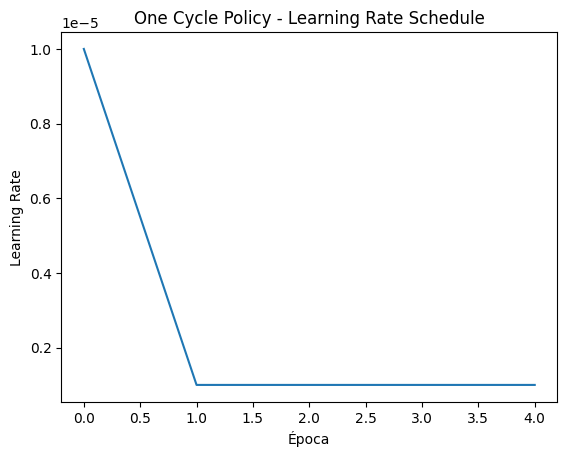

In [84]:
import matplotlib.pyplot as plt  # Corrección en la importación
lrs = [one_cycle_scheduler(epoch, initial_learning_rate) for epoch in range(epochs)]
plt.plot(range(epochs), lrs)
plt.xlabel("Época")
plt.ylabel("Learning Rate")
plt.title("One Cycle Policy - Learning Rate Schedule")
plt.show()

In [85]:
train_results = model_1.evaluate(train_dataset, verbose=1)

2025-04-01 16:45:54.565430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 39 of 516
2025-04-01 16:46:04.669596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 86 of 516
2025-04-01 16:46:14.391090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 128 of 516
2025-04-01 16:46:24.596481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 156 of 516
2025-04-01 16:46:34.722548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 191 of 516
2025-04-01 16:46:44.745010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 224 of 516
2025-04-01 16:46:54.308221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 155s 149ms/step - loss: 0.6365 - accuracy: 0.6453


In [86]:
# Evaluar en el conjunto de validación
val_results = model_1.evaluate(val_dataset, verbose=1)

9/9 [==============================] - 18s 2s/step - loss: 0.5451 - accuracy: 0.8308


In [87]:
# Evaluar en el conjunto de prueba
test_results = model_1.evaluate(test_dataset, verbose=1)

9/9 [==============================] - 20s 2s/step - loss: 0.7403 - accuracy: 0.5385


In [89]:
print("\nResultados Finales:")
print(f"Train - Loss: {train_results[0]}, Accuracy: {train_results[1]}")
print(f"Val - Loss: {val_results[0]}, Accuracy: {val_results[1]}")
print(f"Test - Loss: {test_results[0]}, Accuracy: {test_results[1]}")


Resultados Finales:
Train - Loss: 0.6364993453025818, Accuracy: 0.645348846912384
Val - Loss: 0.5450628995895386, Accuracy: 0.8307692408561707
Test - Loss: 0.7402907609939575, Accuracy: 0.5384615659713745


### Gráfica Epochs vs Loss

In [90]:
history_full

{'loss': [0.6525583863258362,
  0.6469345688819885,
  0.6179778575897217,
  0.6086309552192688],
 'val_loss': [0.5450628995895386,
  0.5661141276359558,
  0.5781829953193665,
  0.5780520439147949]}

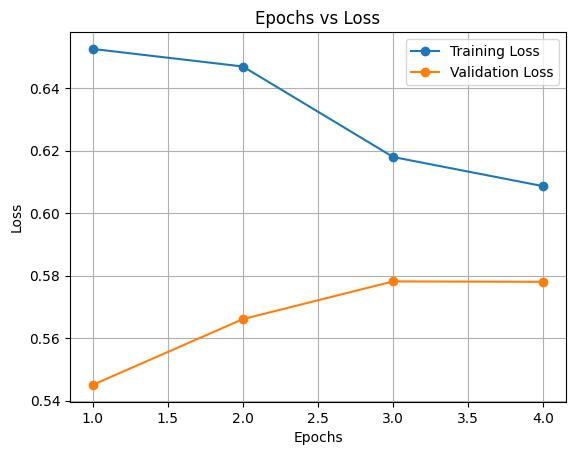

In [91]:
import matplotlib.pyplot as plt
# Extraer la pérdida de entrenamiento y validación
loss = history_full['loss']
val_loss = history_full['val_loss']

# Crear la gráfica
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')

# Etiquetas y título
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.grid(True)
plt.show()

### Visualización del Modelo con TSNE

Num samples: 65, Usando perplexity=10


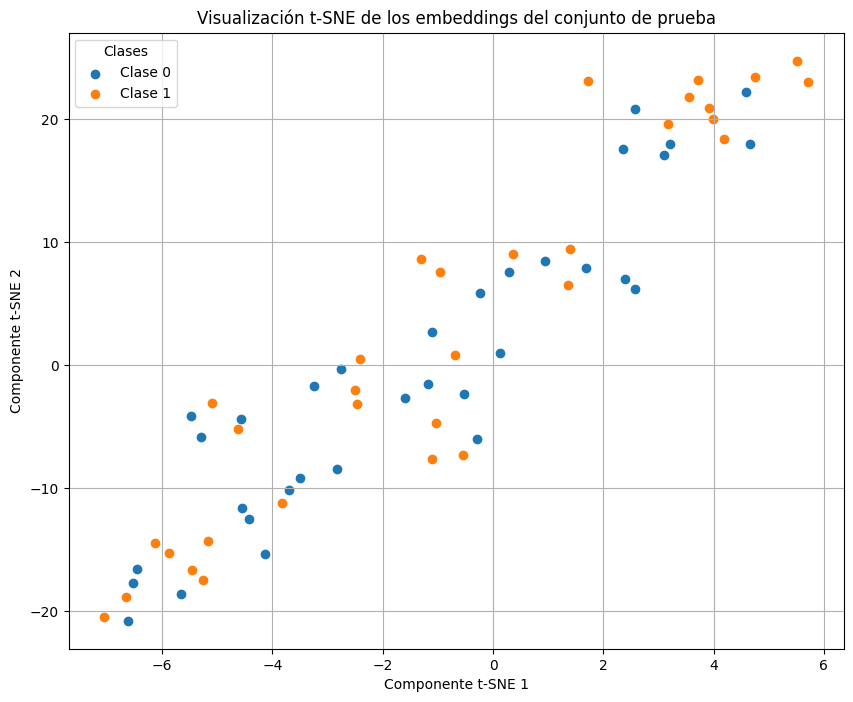

In [92]:
from sklearn.manifold import TSNE

# Obtener las representaciones del modelo
x_test = model_1.predict(test_dataset)  # Extrae los embeddings
y_test = np.concatenate([y for _, y in test_dataset])  # Obtener etiquetas reales

# Verificar el número de muestras
num_samples = x_test.shape[0]
perplexity_value = min(10, num_samples - 1)  # Ajustar perplexity dinámicamente

print(f"Num samples: {num_samples}, Usando perplexity={perplexity_value}")

# Aplicar t-SNE con un perplexity válido
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
x_test_tsne = tsne.fit_transform(x_test)

# Visualización
plt.figure(figsize=(10, 8))
for i in np.unique(y_test):
    idx = np.where(y_test == i)[0]
    plt.scatter(x_test_tsne[idx, 0], x_test_tsne[idx, 1], label=f"Clase {i}")

plt.title("Visualización t-SNE de los embeddings del conjunto de prueba")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()

## I3D + ConvLSTM2D

In [93]:
from tensorflow.keras.layers import (ConvLSTM2D, TimeDistributed, Dense, 
                                    Flatten, GlobalAveragePooling2D, 
                                    Dropout, BatchNormalization)
from tensorflow.keras import Model

class I3D_ConvLSTM(Model):
    def __init__(self, num_classes, endpoint="Mixed_5c"):
        super(I3D_ConvLSTM, self).__init__()
        
        # Modelo base Inception I3D
        self.i3d = InceptionI3d(num_classes=num_classes, is_training=True, final_endpoint=endpoint)
        
        # Capa ConvLSTM2D para modelar información temporal
        self.conv_lstm = ConvLSTM2D(
            filters=64, 
            kernel_size=(3, 3),
            padding='same',
            return_sequences=True,  # Mantener la dimensión temporal
            dropout=0.2,
            recurrent_dropout=0.2
        )
        
        # Batch Normalization después de ConvLSTM
        self.batch_norm = BatchNormalization()
        
        # Global Average Pooling para reducir dimensionalidad
        self.global_avg_pool = GlobalAveragePooling2D()  # Cambio a 2D
        
        # Dropout para regularización
        self.dropout = Dropout(0.3)
        
        # Capa completamente conectada final
        self.fc = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        """Entrada esperada: (batch_size, num_frames, height, width, channels)"""
        
        # Extraer características con I3D
        features, _ = self.i3d(inputs)  # (batch_size, num_frames, 7, 7, 1024)
        
        # Aplicar ConvLSTM2D sobre la dimensión temporal
        lstm_out = self.conv_lstm(features)  # (batch_size, num_frames, 7, 7, 64)
        
        # Tomar solo el último frame de la salida de LSTM para clasificación
        lstm_out = lstm_out[:, -1, :, :, :]  # (batch_size, 7, 7, 64)

        # Batch Normalization
        x = self.batch_norm(lstm_out, training=training)
        
        # Global Average Pooling
        x = self.global_avg_pool(x)
        
        # Dropout para regularización
        x = self.dropout(x, training=training)
        
        # Capa de salida
        logits = self.fc(x)
        
        return logits

In [94]:
# Crear el DataModule
data_module = VideoDataModule(train_df, valid_df, test_df, batch_size=8)
# Obtener los datasets
train_dataset = data_module.train_dataset()
val_dataset = data_module.val_dataset()
test_dataset = data_module.test_dataset()

### Modelo

In [95]:
epochs = 5  # Número de épocas
max_learning_rate = 0.1  # Ejemplo
initial_learning_rate = 1e-5  # Ejemplo
num_classes = 2

In [96]:
model_2 = I3D_ConvLSTM(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_2.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [97]:
checkpoint_dir = "checkpoints/i3dLstm_model"
os.makedirs(checkpoint_dir, exist_ok=True)

last_epoch_file = os.path.join(checkpoint_dir, "last_epoch.npy")
history_file = os.path.join(checkpoint_dir, "history.npy")

# Callback para guardar TODAS las épocas
full_history_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "epoch_{epoch:02d}"),
    save_freq='epoch',
    save_weights_only=True
)

# Callback para guardar solo el MEJOR modelo
best_model_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model"),
    monitor="val_loss",
    mode="min",
    save_best_only=True
)

# Intentar cargar la última época guardada
if os.path.exists(last_epoch_file):
    initial_epoch = int(np.load(last_epoch_file))
    model_2.load_weights(os.path.join(checkpoint_dir, "best_model"))
    print(f"Resuming training from epoch {initial_epoch}")
else:
    initial_epoch = 0
    print("Starting training from scratch.")

# Callback para detener el entrenamiento si no hay mejora
early_stop_callback = EarlyStopping(
    monitor="val_loss", 
    patience=3, 
    mode="min", 
    restore_best_weights=True
)

# Callback para guardar el mejor modelo
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model"),
    save_best_only=True,
    monitor="val_loss",
    mode="min",
    save_weights_only=True
)

lr_scheduler = LearningRateScheduler(one_cycle_scheduler)

# Callback para guardar la época actual
class EpochSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        np.save(last_epoch_file, epoch + 1)  # Guardar la siguiente época a entrenar

epoch_saver_callback = EpochSaver()

# Callback para guardar historial después de cada época
class HistorySaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            history_full['loss'].append(logs.get('loss', None))
            history_full['val_loss'].append(logs.get('val_loss', None))
            np.save(history_file, history_full)  # Guardar historial actualizado

history_saver_callback = HistorySaver()

# Cargar historial previo si existe
if os.path.exists(history_file):
    history_full = np.load(history_file, allow_pickle=True).item()
else:
    history_full = {'loss': [], 'val_loss': []}

# Verificar si el entrenamiento ya ha terminado
if initial_epoch >= epochs:
    print("Training already completed. No new epochs to run.")
else:
    # Entrenar desde la última época
    history = model_2.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        initial_epoch=initial_epoch,
        callbacks=[
            early_stop_callback, 
            checkpoint_callback, 
            lr_scheduler, 
            epoch_saver_callback, 
            full_history_callback, 
            best_model_callback,
            history_saver_callback  # Nuevo callback para guardar historial
        ],
        verbose=1
    )

Starting training from scratch.
Epoch 1/5


/home/aherrerag/anaconda3/envs/proyecto_i3d/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4929: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(
2025-04-01 16:51:24.185720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38 of 516
2025-04-01 16:51:34.381287: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 84 of 516
2025-04-01 16:51:44.201933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 124 of 516
2025-04-01 16:51:54.148639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 153 of 516
2025-04-01 16:52:04.247295: I tensorflow/core/kernels/data/shuffle_datase

65/65 [==============================] - 200s 555ms/step - loss: 0.6775 - accuracy: 0.5930 - val_loss: 0.6065 - val_accuracy: 0.7846
INFO:tensorflow:Assets written to: checkpoints/i3dLstm_model/best_model/assets
Epoch 2/5


2025-04-01 16:54:51.528513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38 of 516
2025-04-01 16:55:01.645721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 84 of 516
2025-04-01 16:55:11.437674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 124 of 516
2025-04-01 16:55:21.460834: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 153 of 516
2025-04-01 16:55:31.387632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 185 of 516
2025-04-01 16:55:41.490936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 219 of 516
2025-04-01 16:55:51.495460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 181s 521ms/step - loss: 0.6641 - accuracy: 0.6182 - val_loss: 0.6287 - val_accuracy: 0.7385
Epoch 3/5


2025-04-01 16:57:54.578754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 38 of 516
2025-04-01 16:58:04.727099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 85 of 516
2025-04-01 16:58:14.604204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 126 of 516
2025-04-01 16:58:24.720474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 154 of 516
2025-04-01 16:58:34.755096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 190 of 516
2025-04-01 16:58:44.880569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 221 of 516
2025-04-01 16:58:55.015689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 180s 520ms/step - loss: 0.6189 - accuracy: 0.6609 - val_loss: 0.6137 - val_accuracy: 0.7077
Epoch 4/5


2025-04-01 17:00:57.069461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 37 of 516
2025-04-01 17:01:07.075219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 82 of 516
2025-04-01 17:01:17.231924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 121 of 516
2025-04-01 17:01:27.090761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 151 of 516
2025-04-01 17:01:37.142045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 182 of 516
2025-04-01 17:01:47.083148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 217 of 516
2025-04-01 17:01:57.032599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 181s 519ms/step - loss: 0.6220 - accuracy: 0.6822 - val_loss: 0.6024 - val_accuracy: 0.7231
INFO:tensorflow:Assets written to: checkpoints/i3dLstm_model/best_model/assets
Epoch 5/5


2025-04-01 17:04:23.538354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 37 of 516
2025-04-01 17:04:33.662312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 82 of 516
2025-04-01 17:04:43.915094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 121 of 516
2025-04-01 17:04:53.581658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 150 of 516
2025-04-01 17:05:03.606821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 180 of 516
2025-04-01 17:05:13.653864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 216 of 516
2025-04-01 17:05:23.606298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 183s 519ms/step - loss: 0.6388 - accuracy: 0.6085 - val_loss: 0.5959 - val_accuracy: 0.7231
INFO:tensorflow:Assets written to: checkpoints/i3dLstm_model/best_model/assets


In [98]:
train_results = model_2.evaluate(train_dataset, verbose=1)

2025-04-01 17:08:11.922702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 35 of 516
2025-04-01 17:08:22.150324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 78 of 516
2025-04-01 17:08:31.915593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 113 of 516
2025-04-01 17:08:41.873289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 142 of 516
2025-04-01 17:08:51.812402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 173 of 516
2025-04-01 17:09:01.830459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 209 of 516
2025-04-01 17:09:11.834078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (t

65/65 [==============================] - 160s 110ms/step - loss: 0.6072 - accuracy: 0.6783


In [99]:
# Evaluar en el conjunto de validación
val_results = model_2.evaluate(val_dataset, verbose=1)

9/9 [==============================] - 18s 2s/step - loss: 0.5959 - accuracy: 0.7231


In [100]:
# Evaluar en el conjunto de prueba
test_results = model_2.evaluate(test_dataset, verbose=1)

9/9 [==============================] - 20s 2s/step - loss: 0.6724 - accuracy: 0.5077


In [101]:
print("\nResultados Finales:")
print(f"Train - Loss: {train_results[0]}, Accuracy: {train_results[1]}")
print(f"Val - Loss: {val_results[0]}, Accuracy: {val_results[1]}")
print(f"Test - Loss: {test_results[0]}, Accuracy: {test_results[1]}")


Resultados Finales:
Train - Loss: 0.6071980595588684, Accuracy: 0.6782945990562439
Val - Loss: 0.5958573222160339, Accuracy: 0.7230769395828247
Test - Loss: 0.672350287437439, Accuracy: 0.5076923370361328


### Evolución del Learning rate

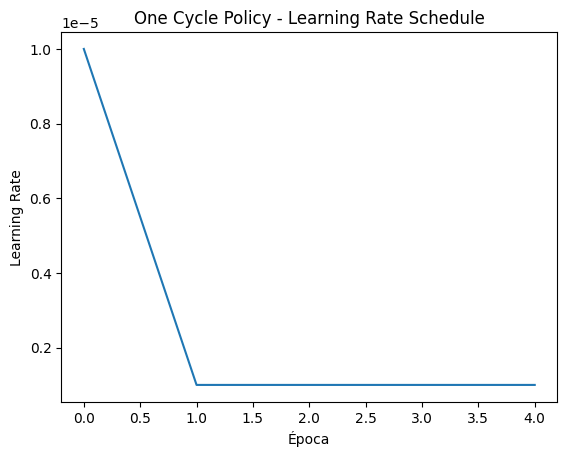

In [102]:
import matplotlib.pyplot as plt  # Corrección en la importación
lrs = [one_cycle_scheduler(epoch, initial_learning_rate) for epoch in range(epochs)]
plt.plot(range(epochs), lrs)
plt.xlabel("Época")
plt.ylabel("Learning Rate")
plt.title("One Cycle Policy - Learning Rate Schedule")
plt.show()

### Gráfica Epochs vs Loss

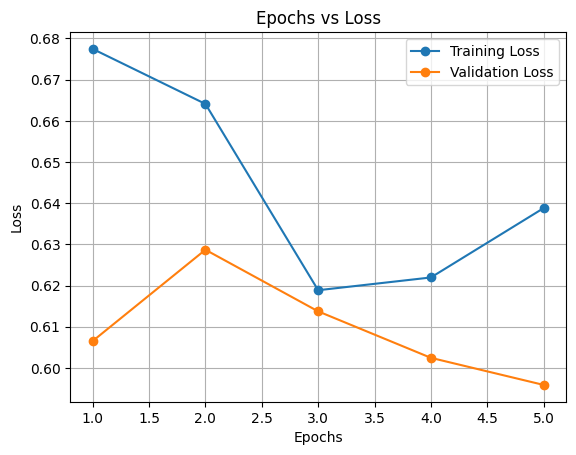

In [103]:
import matplotlib.pyplot as plt

# Extraer la pérdida de entrenamiento y validación
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear la gráfica
plt.plot(range(1, len(loss) + 1), loss, label='Training Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')

# Etiquetas y título
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.grid(True)
plt.show()

### Visualización del Modelo con TSNE

Num samples: 65, Usando perplexity=10


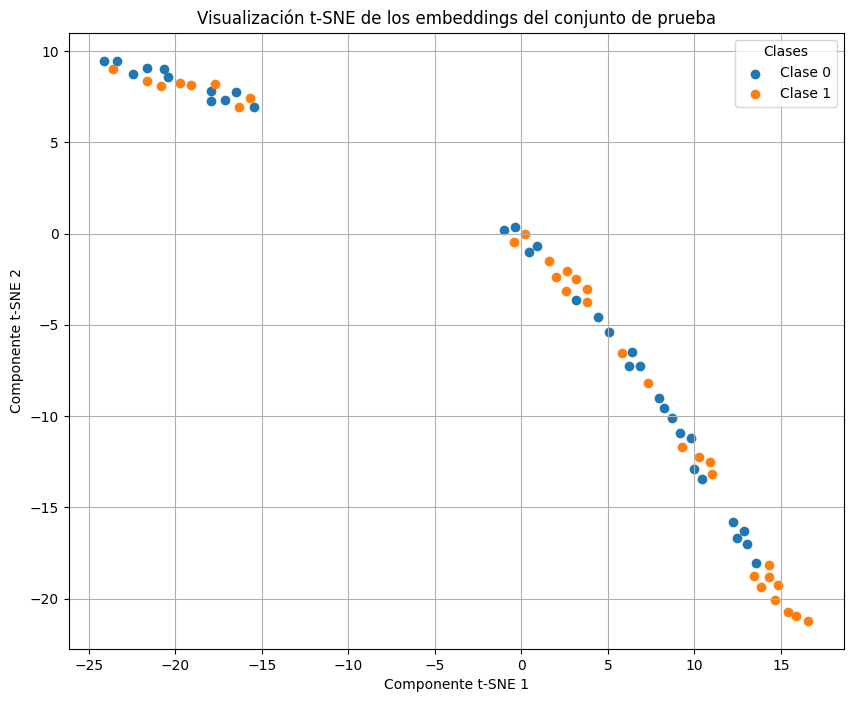

In [104]:
from sklearn.manifold import TSNE

# Obtener las representaciones del modelo
x_test = model_2.predict(test_dataset)  # Extrae los embeddings
y_test = np.concatenate([y for _, y in test_dataset])  # Obtener etiquetas reales

# Verificar el número de muestras
num_samples = x_test.shape[0]
perplexity_value = min(10, num_samples - 1)  # Ajustar perplexity dinámicamente

print(f"Num samples: {num_samples}, Usando perplexity={perplexity_value}")

# Aplicar t-SNE con un perplexity válido
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
x_test_tsne = tsne.fit_transform(x_test)

# Visualización
plt.figure(figsize=(10, 8))
for i in np.unique(y_test):
    idx = np.where(y_test == i)[0]
    plt.scatter(x_test_tsne[idx, 0], x_test_tsne[idx, 1], label=f"Clase {i}")

plt.title("Visualización t-SNE de los embeddings del conjunto de prueba")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend(title="Clases")
plt.grid(True)
plt.show()

## Comparación de modelos

In [43]:
# Evaluar los modelos en el conjunto de prueba
loss_1, acc_1 = model_1.evaluate(X_test, y_test)
loss_2, acc_2 = model_2.evaluate(X_test, y_test)

print(f"KerasI3D - Loss: {loss_1}, Accuracy: {acc_1}")
print(f"I3D_ConvLSTM - Loss: {loss_2}, Accuracy: {acc_2}")

NameError: name 'X_test' is not defined